In [ ]:
import pandas as pd
import pm4py

# configure the event log file which will be analysed
event_log_file = '../gitlab/gitlab_event_logs_ABCD.parquet.gz'

In [22]:
event_df = pd.read_parquet(event_log_file)
event_df

,id,action,time,case,user,local_case,info1,info2,ns
0,767342,gl_issue_assigned,2024-04-24 08:46:05.325000+00:00,GLI-431-90,1266,GLI-431-90,assigned to @chinthanic,,431
1,11372,gl_issue_created,2024-04-24 08:46:05.280000+00:00,GLI-431-90,1266,GLI-431-90,,,431
2,763046,gl_issue_assigned,2024-04-16 05:48:28.192000+00:00,GLI-431-89,1266,GLI-431-89,assigned to @chinthanic,,431
3,11335,gl_issue_created,2024-04-16 05:48:28.143000+00:00,GLI-431-89,1266,GLI-431-89,,,431
4,756642,gl_issue_assigned,2024-04-02 09:35:21.315000+00:00,GLI-431-88,1094,GLI-431-88,assigned to @indunilud,,431
...,...,...,...,...,...,...,...,...,...
32323,375224,gl_PL_completed,2023-08-07 09:22:56.473000+00:00,GLPL-4816-375224,1094,GLPL-4816-375224,,,4816
32324,2841042,gl_job_started,2023-08-07 09:22:23.881000+00:00,GLPL-4816-375224,1094,GLPL-4816-375224,testing,test,4816
32325,375223,gl_PL_created,2023-08-07 09:15:01.021000+00:00,GLPL-4816-375223,1094,GLPL-4816-375223,,,4816
32326,375223,gl_PL_completed,2023-08-07 09:16:23.725000+00:00,GLPL-4816-375223,1094,GLPL-4816-375223,,,4816


In [23]:
# convert the pandas dataframe to pm4py event log and check start activities to verify
event_log = pm4py.convert_to_event_log(event_df.rename(columns={'case': 'case:concept:name', 'time': 'time:timestamp','action': 'concept:name'}))
pm4py.get_start_activities(event_log)

{'gl_issue_assigned': 451,
 'gl_issue_created': 147,
 'gl_branch_created': 211,
 'gl_MR_created': 364,
 'gl_PL_created': 2013}

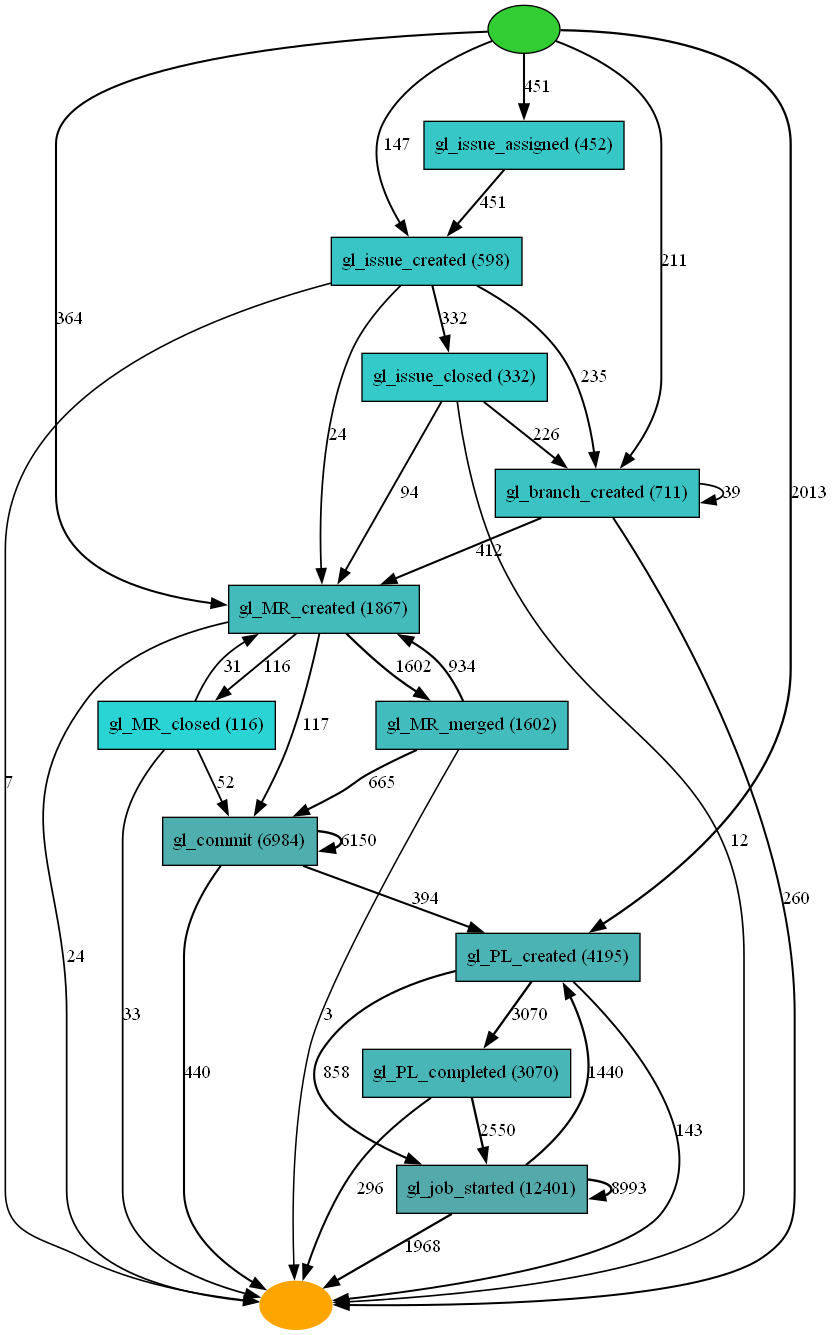

In [24]:
# use heuristic miner to derive process map and plot it
heu_net = pm4py.discover_heuristics_net(event_log, dependency_threshold=0.70)
pm4py.view_heuristics_net(heu_net)

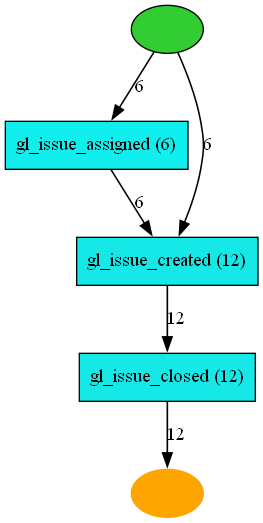

In [25]:
# filter event log to include issues which has been closed; hence which has completed the process.
# so we will not catch incomplete processes and make the mind map garbage
issue_focus_event_log = pm4py.filter_end_activities(event_log, ['gl_issue_closed'] )
heu_net = pm4py.discover_heuristics_net(issue_focus_event_log, dependency_threshold=0.70)
pm4py.view_heuristics_net(heu_net)

In [42]:
# the event log for gitlab by default will consider all pipeline jobs as same action.
# however, if needed the info fields contain additional category information.
# below function makes use of this to provide better process map, for a given project (namespace)

def proj_get_map_by_info_column(project):
	proj_df = event_df.query('ns=="' + str(project) + '"')
	proj_df = proj_df.query('~(info1=="" and action=="gl_job_started")')
	proj_df.loc[proj_df['action'] == "gl_job_started", 'action'] = proj_df['info1']
	proj_df = proj_df[proj_df['case'].str.startswith('GLI-')]
	proj_df_copy = proj_df.copy()
	proj_event_log = pm4py.convert_to_event_log(pm4py.format_dataframe(proj_df_copy, case_id='case', activity_key='action', timestamp_key='time'))
	proj_event_log_filtered = pm4py.filter_between(proj_event_log,'gl_issue_created', 'gl_issue_closed')
	heu_net = pm4py.discover_heuristics_net(proj_event_log_filtered, dependency_threshold=0.70)
	pm4py.view_heuristics_net(heu_net)

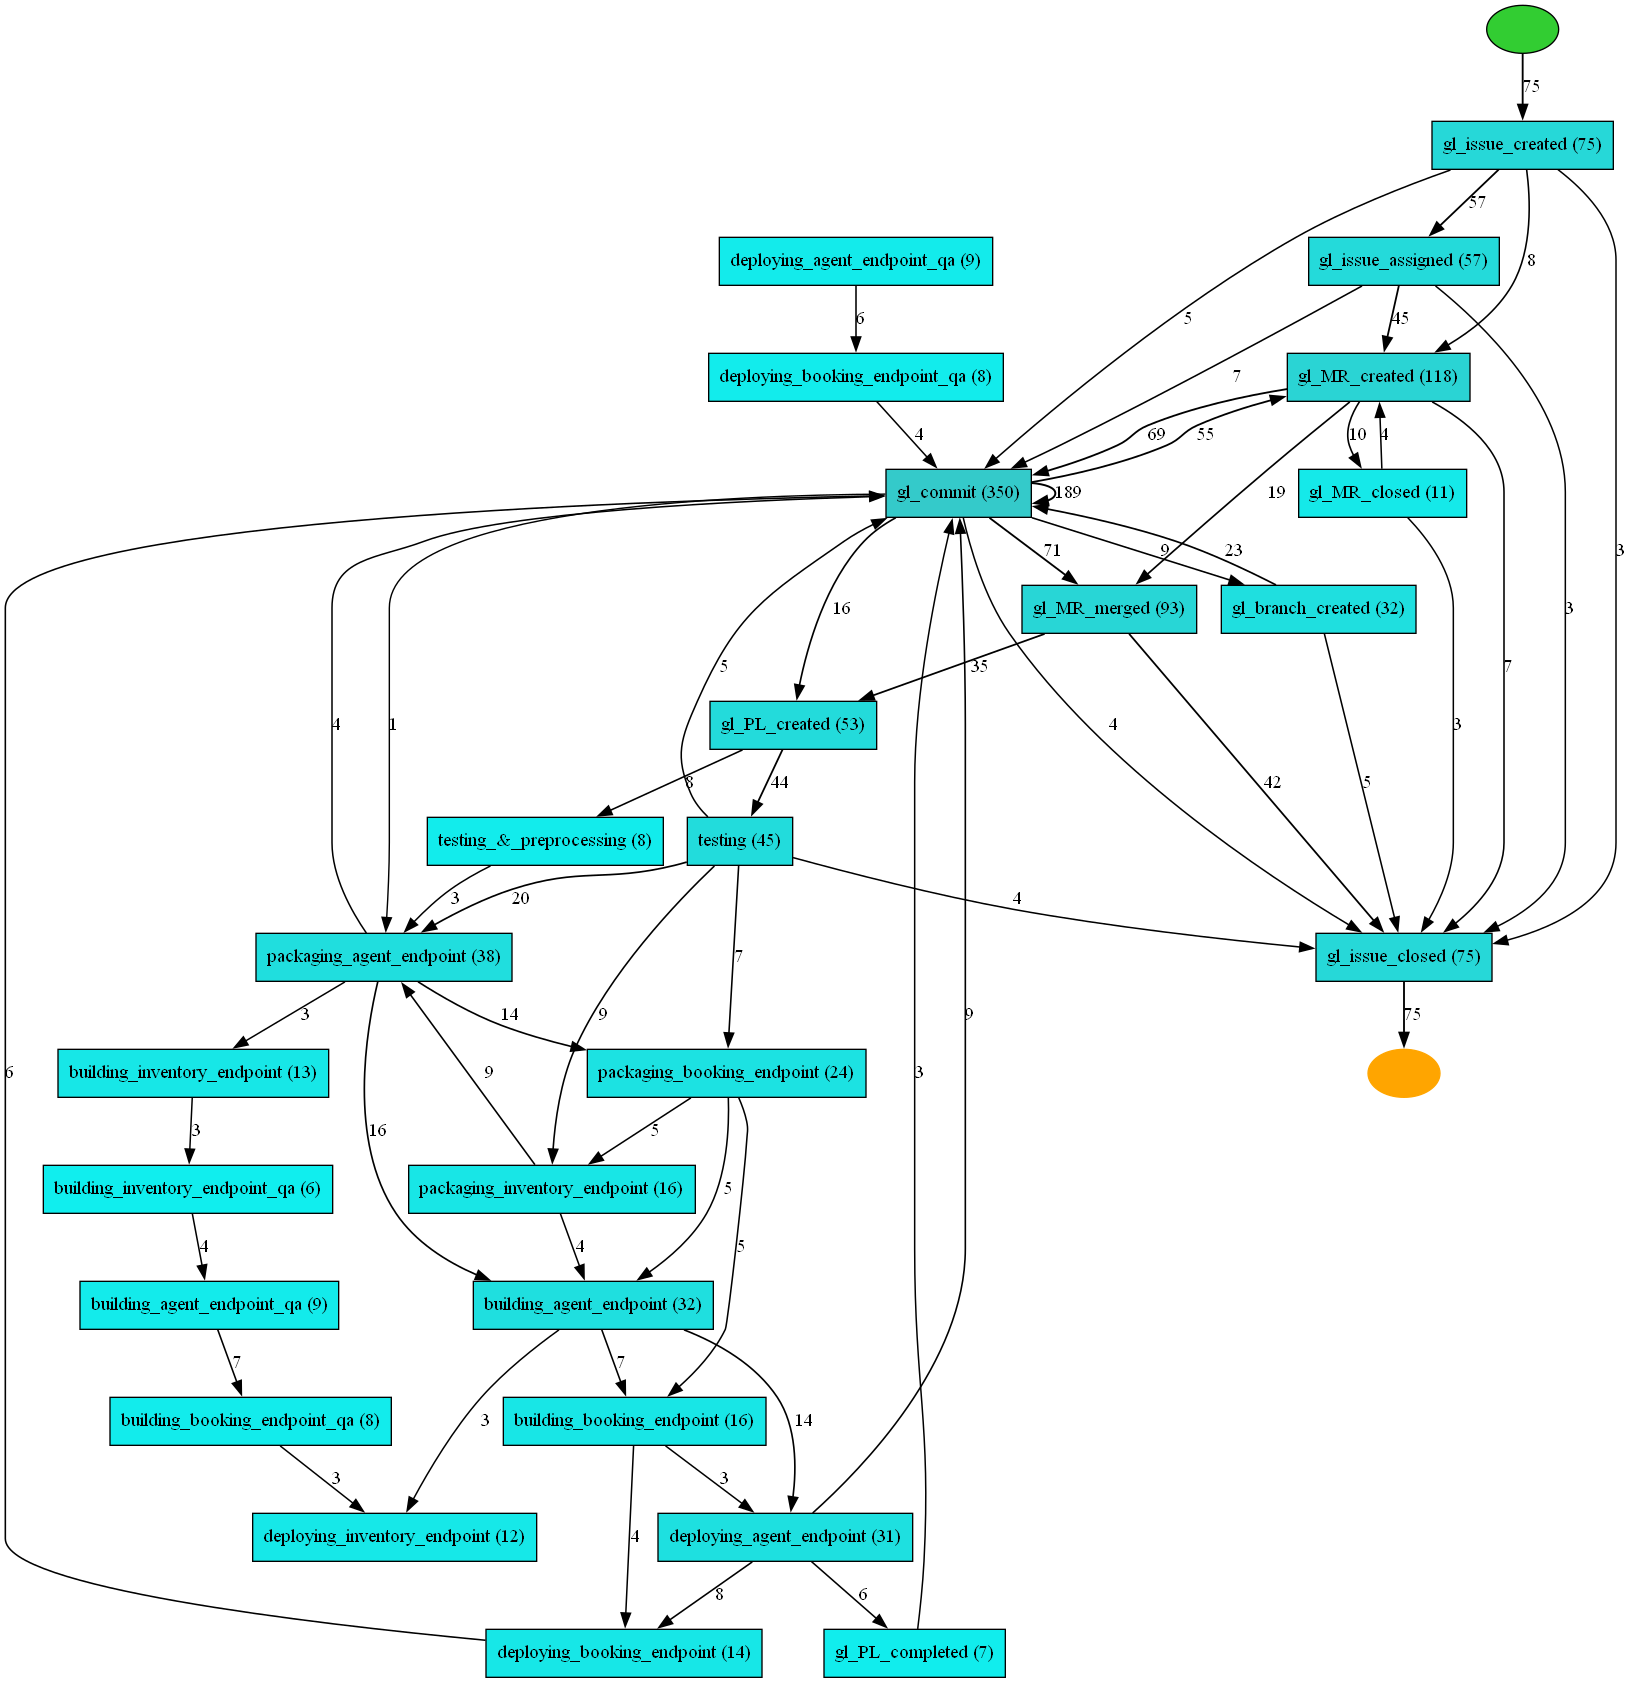

           id             action                             time  \
3253   767415  gl_issue_assigned 2024-04-24 09:26:34.362000+00:00   
3254    11375   gl_issue_created 2024-04-24 09:26:34.317000+00:00   
3255   766153  gl_issue_assigned 2024-04-22 05:06:08.512000+00:00   
3256    11363   gl_issue_created 2024-04-22 05:06:08.458000+00:00   
3257    11356   gl_issue_created 2024-04-19 07:56:20.129000+00:00   
...       ...                ...                              ...   
13973   45454            testing 2018-10-11 08:38:55.565000+00:00   
13974   12511      gl_PL_created 2018-10-11 08:33:07.988000+00:00   
13975   12511    gl_PL_completed 2018-10-11 08:36:01.397000+00:00   
13976   12507      gl_PL_created 2018-10-11 08:30:29.266000+00:00   
13977   12507    gl_PL_completed 2018-10-11 08:30:29.265000+00:00   

              case  user      local_case                    info1 info2   ns  \
3253   GLI-270-188  1266     GLI-270-188  assigned to @chinthanic        270   
3254   GLI-

In [43]:
proj_get_map_by_info_column(270)

In [52]:
from pm4py.algo.evaluation.generalization import algorithm as generalization_evaluator
from pm4py.algo.evaluation.simplicity import algorithm as simplicity_evaluator
from pm4py.algo.analysis.woflan import algorithm as woflan

def get_model_suitability(input_log, net, initial_marking, final_marking, soundness_required: bool = True) -> dict:
    fitness = pm4py.fitness_token_based_replay(input_log, net, initial_marking, final_marking)
    print('fitness: ' + str(fitness['average_trace_fitness']))
    precision = pm4py.precision_token_based_replay(input_log, net, initial_marking, final_marking)
    print('precision: ' + str(precision))
    generalization = generalization_evaluator.apply(input_log, net, initial_marking, final_marking)
    print('generalization: ' + str(generalization))
    simplicity = simplicity_evaluator.apply(net)
    print('simplicity: ' + str(simplicity))
    is_sound = False
    # if soundness test not done, it will give 0
    # inductive petri nets are slow to find soundness
    if soundness_required:
        is_sound = woflan.apply(net, initial_marking, final_marking, parameters={woflan.Parameters.RETURN_ASAP_WHEN_NOT_SOUND: True,woflan.Parameters.PRINT_DIAGNOSTICS: False,woflan.Parameters.RETURN_DIAGNOSTICS: False})
    print(fitness)
    f_measure = (2 * fitness['average_trace_fitness'] * precision) / (fitness['average_trace_fitness'] + precision)
    return_dict = {'fitness': fitness['average_trace_fitness'], 'precision': precision, 'generalization': generalization, 'simplicity': simplicity, 'f_measure': f_measure, 'is_sound': is_sound }
    print(str(return_dict))
    return return_dict

In [53]:
# get model suitability metrics
suitability_metrics = {}
net, initial_marking, final_marking = pm4py.discover_petri_net_heuristics(event_log, dependency_threshold=0.99)
suitability_metrics['gl_issue_heuristic_D99'] = get_model_suitability(event_log, net, initial_marking, final_marking)

replaying log with TBR, completed traces :: 100%|██████████| 500/500 [00:02<00:00, 245.69it/s]


fitness: 0.967706847199462


replaying log with TBR, completed traces :: 100%|██████████| 13021/13021 [00:06<00:00, 1867.46it/s]


precision: 0.8239581100529749


replaying log with TBR, completed traces :: 100%|██████████| 500/500 [00:02<00:00, 246.60it/s]

generalization: 0.8846755919323628
simplicity: 0.5670103092783505
{'perc_fit_traces': 70.77840552416824, 'average_trace_fitness': 0.967706847199462, 'log_fitness': 0.9758157290474041, 'percentage_of_fitting_traces': 70.77840552416824}
{'fitness': 0.967706847199462, 'precision': 0.8239581100529749, 'generalization': 0.8846755919323628, 'simplicity': 0.5670103092783505, 'f_measure': 0.8900658593295788, 'is_sound': False}


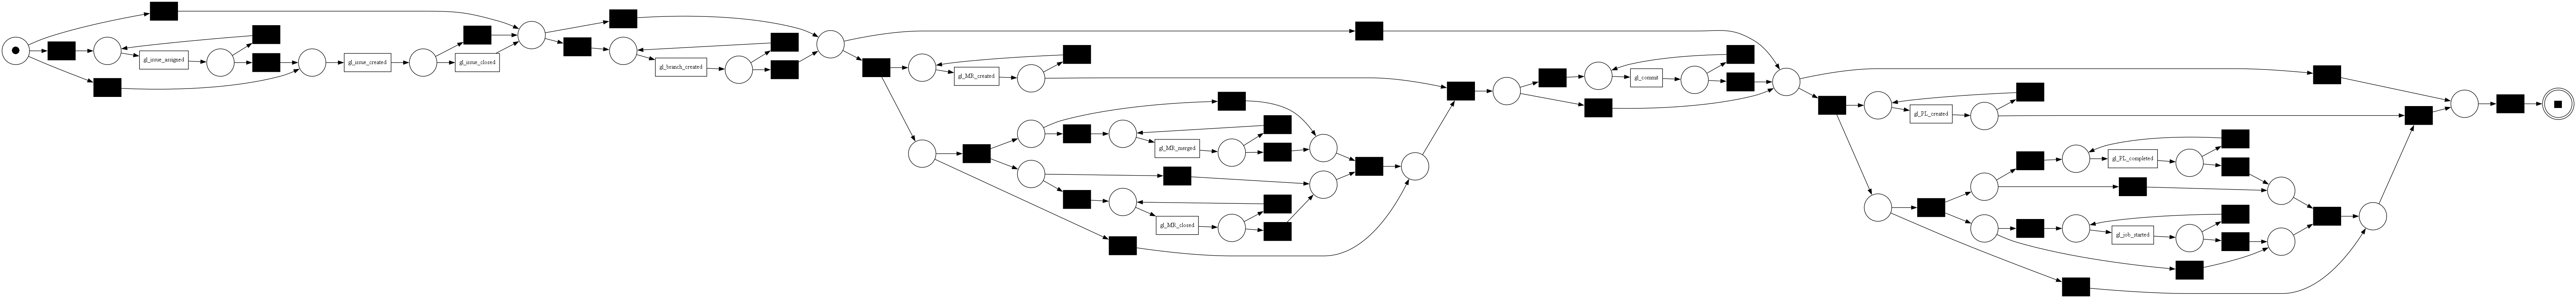

In [54]:
# lets try the inductive miner
from pm4py.visualization.petri_net import visualizer as pn_visualizer
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(event_log)
# visualize the petri net (as reference)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [ ]:
suitability_metrics['gl_issue_inductive_default'] = get_model_suitability(event_log, net, initial_marking, final_marking, False)

In [49]:
metrics_list = []
indices = []
for model_name in suitability_metrics:
    metric_dict = suitability_metrics[model_name].copy()
    indices.append(model_name)
    metrics_list.append(metric_dict)
metrics_df = pd.DataFrame(metrics_list, index=indices)
metrics_df

,fitness,precision,generalization,simplicity,f_measure,is_sound
gl_issue_heuristic_D99,0.967707,0.823958,0.884676,0.56701,0.890066,False


c:\Users\lmpeiris\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\lmpeiris\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


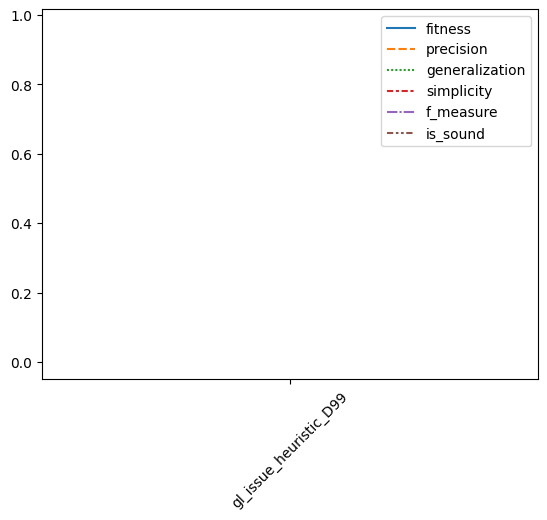

In [50]:
import seaborn as sns
ax = sns.lineplot(metrics_df, orient='x')
ax.tick_params(axis='x', rotation=45)